In [3]:
import pandas as pd
import h5py
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from pathlib import Path
import itertools as it

from meta_feature import dataset_ids_CC18, learner_zoo
from utils import anchor_list_denser, successive_halving, get_datasets_and_learner_zoo_for_excluded_learners

learner_zoo, learner_zoo_abbrv, dataset_nofs, dataset_minmaxfs, dataset_standardfs = get_datasets_and_learner_zoo_for_excluded_learners(excluded_learners=[])

In [4]:
def get_schedule_for_budget_increase(b):
    return anchor_list_denser[::b]

get_schedule_for_budget_increase(8)

array([     16,      32,      64,     128,     256,     512,    1024,
          2048,    4096,    8192,   16384,   32768,   65536,  131072,
        262144,  524288, 1048576, 2097152])

In [5]:
def successive_halving(learning_curves, budget, budget_increase, dropout_rate, active_mask=None, _history={}):
    
    # only on first call, activate all algorithms
    if active_mask is None:
        active_mask = np.ones(len(learning_curves))
    
    # append the current ensemble
    indices_of_active_algorithms = [int(i) for i in np.where(active_mask)[0]]
    _history[budget] = indices_of_active_algorithms
    
    # recursive cancellation
    current_population_size = len(indices_of_active_algorithms)
    if current_population_size <= 1 or budget >= learning_curves.shape[1]:
        return _history
    
    # determine currently best
    new_population_size = max(1, (current_population_size - dropout_rate) if dropout_rate >= 1 else int(np.round(current_population_size * (1 - dropout_rate))))
    sorted_performances = np.argsort(learning_curves[:, budget])
    survivors = [int(i) for i in sorted_performances if i in indices_of_active_algorithms][:new_population_size]
    new_active_mask = np.array([i in survivors for i in range(len(learning_curves))])
    
    # recurse
    return successive_halving(
        learning_curves=learning_curves,
        budget=budget + budget_increase,
        budget_increase=budget_increase,
        dropout_rate=dropout_rate,
        active_mask=new_active_mask,
        _history=_history
    )

def get_successive_halving_result_matrix(lc_db, start_budget, dropout_rate, budget_increase, max_k=10, num_outer_splits=5, regrets=True, verbose=False, quiet=False):

    result_matrix = np.zeros((lc_db.shape[0], num_outer_splits, max_k))
    for dataset_idx, lcs_on_dataset in enumerate(lc_db):
        if verbose:
            print(f"Next dataset (index {dataset_idx}).")
        for outer_seed in range(num_outer_splits):
            if verbose:
                print(f"Next test seed ({outer_seed}).")
            mean_val_curve = lcs_on_dataset[:, outer_seed, :, :, 1].mean(axis=1)

            # cut down curve to the observable part
            min_index = len(anchor_list_denser)
            for i, alg_curve in enumerate(mean_val_curve):

                # determine whether this learner has nan values and where these start
                indices_with_nan = np.where(np.isnan(alg_curve))[0]
                has_nan_values = len(indices_with_nan) > 0

                if has_nan_values:
                    first_index_with_nan = min(indices_with_nan)
                    if first_index_with_nan == 0:  # starts with nan values
                        if not quiet:
                            print(f"WARNING: Algorithm #{i} starts with nan entries in the mean curve for dataset idx {dataset_idx} on outer seed {outer_seed}. Changing nan scores to 2")

                        # In this case, treat all nans as 2-values (worst possible)
                        mean_val_curve[i, np.isnan(mean_val_curve[i])] = 2
                    
                    else: # starts with values. In this case, we assume that nothing comes after first nan
                        min_index = min(min_index, first_index_with_nan)

            mean_val_curve = mean_val_curve[:, :min_index]

            history = successive_halving(
                learning_curves=mean_val_curve,
                budget=start_budget,
                budget_increase=budget_increase,
                dropout_rate=dropout_rate,
                _history={}
            )
            if verbose:
                print(history)

            # sanity check of result
            prev_pop = None
            for i, pop in history.items():
                if prev_pop is not None:
                    assert set(pop).issubset(set(prev_pop))
                prev_pop = pop
            
            # determine whether best algorithm is selected
            last_population = list(history.values())[-1]
            if len(last_population) != 1:
                print("warning, not converged to size 1. Taking  first element")
                last_population = last_population[:1]
            if verbose:
                print(f"{last_population=}")
            
            if regrets:
                assert max_k == 1, "If regrets is activated, make sure that max_k is 1"
                result_matrix[dataset_idx, outer_seed, 0] = mean_val_curve[last_population[0], -1] - np.min(mean_val_curve[:, -1])
            else:
                final_ranking = np.argsort(mean_val_curve[:, -1])
                if verbose:
                    print(f"Final ranking at anchor {mean_val_curve.shape[1]} is {final_ranking} based on performances {np.round(mean_val_curve[:, -1], 3)}")
                for k_minus_one in range(max_k):
                    result_matrix[dataset_idx, outer_seed, k_minus_one] = last_population[0] in final_ranking[:k_minus_one + 1]
    return result_matrix

In [12]:
#least_crossing_learners = ['SVC_sigmoid', 'PassiveAggressive', 'RidgeClassifier', 'BernoulliNB', 'ComplementNB']
#most_crossing_learners = ['SVC_rbf', 'ExtraTrees', 'LDA', 'KNN', 'NearestCentroid']
least_crossing_learners = ['SVC_sigmoid', 'Decision Tree', 'ExtraTree', 'ens.ExtraTrees', 'ens.RandomForest']
most_crossing_learners = ['SVC_rbf', 'Perceptron', 'LDA', 'KNN', 'NearestCentroid']

In [13]:
def get_sh_ablation_results(
    database,
    max_k=10,
    d_dropout_rates = [0.5, 1, 2, 4],
    d_start_budgets = [0, 1, 2, 3, 4, 7, 15],
    d_budget_increases = [1, 2, 4, 8],
    considered_datasets=None,
    selected_learners=None
    ):
    
    if selected_learners is not None:
        max_k = min(max_k, len(selected_learners) - 1)

    pbar = tqdm(total = len(d_dropout_rates) * len(d_start_budgets) * len(d_budget_increases))

    dataset_slice = slice(None) if considered_datasets is None else [dataset_ids_CC18.index(i) for i in considered_datasets]
    learner_slice = slice(None) if selected_learners is None else [learner_zoo.index(l) for l in selected_learners]
    _lc_db = database[dataset_slice, learner_slice]
    lc_db = _lc_db.reshape(
        database.shape[0] if considered_datasets is None else len(considered_datasets),
        database.shape[1] if selected_learners is None else len(selected_learners),
        database.shape[2],
        database.shape[3],
        database.shape[4],
        database.shape[5]
    )

    rows = []
    for dropout_rate in d_dropout_rates:
        for start_budget in d_start_budgets:
            for budget_increase in d_budget_increases:

                matrix_of_kbest_result_selection = get_successive_halving_result_matrix(
                    lc_db=lc_db,
                    dropout_rate=dropout_rate,
                    budget_increase=budget_increase,
                    max_k=max_k,
                    start_budget=start_budget,
                    verbose=False,
                    quiet=True,
                    regrets=False
                )

                # regrets
                matrix_of_regrets = get_successive_halving_result_matrix(
                    lc_db=lc_db,
                    dropout_rate=dropout_rate,
                    budget_increase=budget_increase,
                    max_k=1,
                    start_budget=start_budget,
                    verbose=False,
                    quiet=True,
                    regrets=True
                )
                rows.append([considered_datasets, selected_learners, dropout_rate, start_budget, budget_increase, matrix_of_kbest_result_selection, matrix_of_regrets])

                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["dataset_filter", "learner_filter", "dropout_rate", "start_budget", "budget_increase", "kbest_inclusion_rates", "regrets"])

df_results_least_crossing = get_sh_ablation_results(
    database=dataset_minmaxfs,
    d_dropout_rates=[1],
    d_start_budgets=[0, 1, 3, 7, 15],
    d_budget_increases=[1, 2, 4, 8],
    selected_learners=least_crossing_learners,
    max_k=4
)

df_results_most_crossing = get_sh_ablation_results(
    database=dataset_minmaxfs,
    d_dropout_rates=[1],
    d_start_budgets=[0, 1, 3, 7, 15],
    d_budget_increases=[1, 2, 4, 8],
    selected_learners=most_crossing_learners,
    max_k=4
)






















100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first 

warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first element
warning, not converged to size 1. Taking  first 


100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


In [14]:
df_results_least_crossing

,dataset_filter,learner_filter,dropout_rate,start_budget,budget_increase,kbest_inclusion_rates,regrets
0,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,1,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
1,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
2,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,4,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
3,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,8,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
4,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,1,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
5,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
6,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,4,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
7,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,8,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
8,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,3,1,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
9,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,3,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."


In [15]:
df_results = pd.concat([df_results_least_crossing, df_results_most_crossing])
df_results

,dataset_filter,learner_filter,dropout_rate,start_budget,budget_increase,kbest_inclusion_rates,regrets
0,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,1,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
1,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
2,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,4,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
3,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,0,8,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
4,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,1,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
5,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
6,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,4,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
7,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,1,8,"[[[0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0006944444444444..."
8,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,3,1,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."
9,None,"[SVC_sigmoid, Decision Tree, ExtraTree, ens.Ex...",1,3,2,"[[[0.0, 0.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], ...","[[[0.0027777777777777905], [0.0], [0.001388888..."


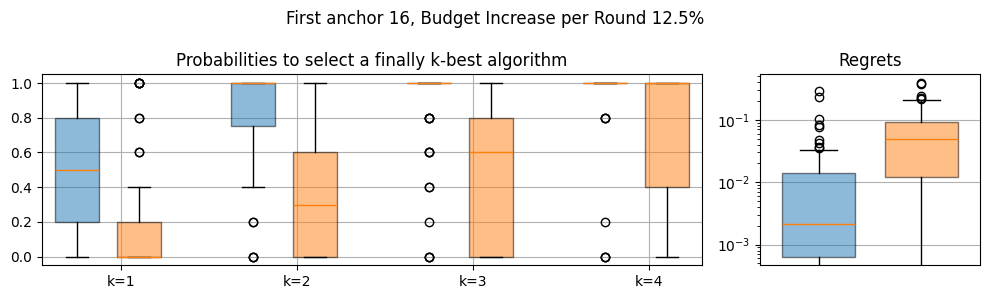

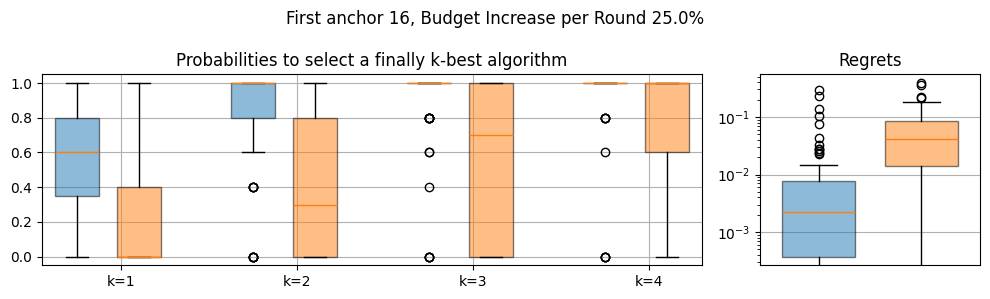

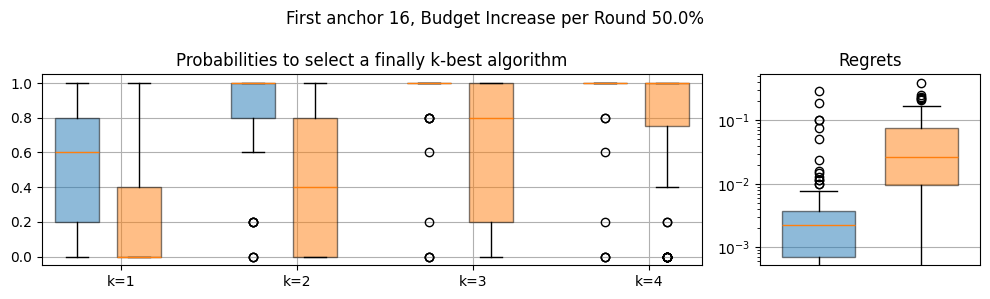

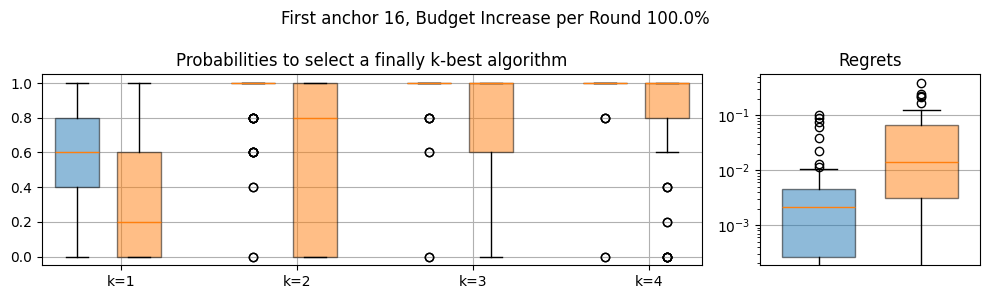

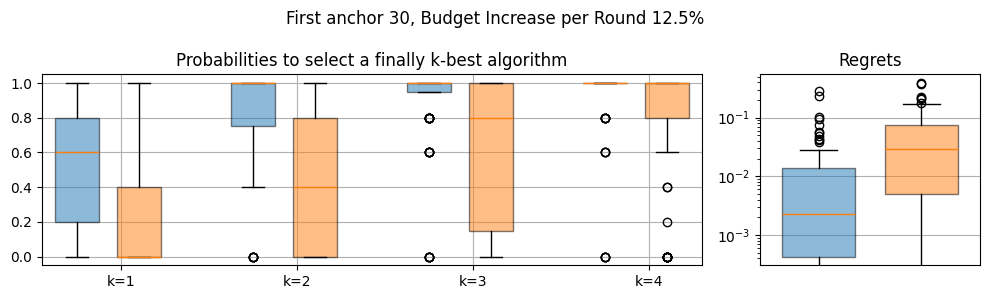

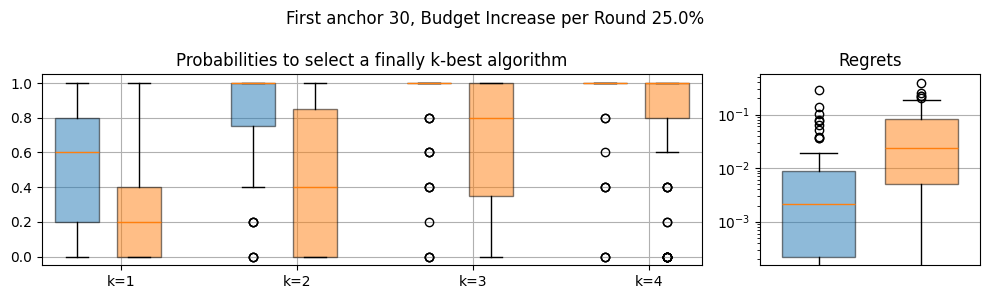

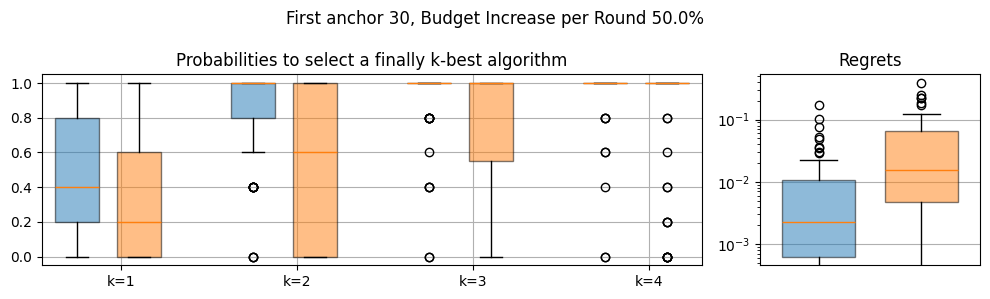

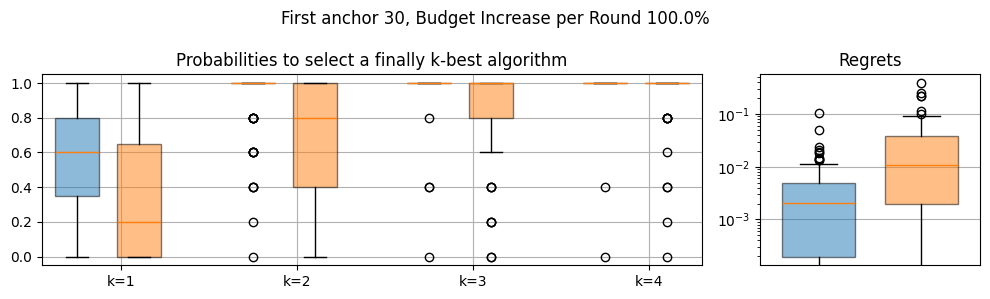

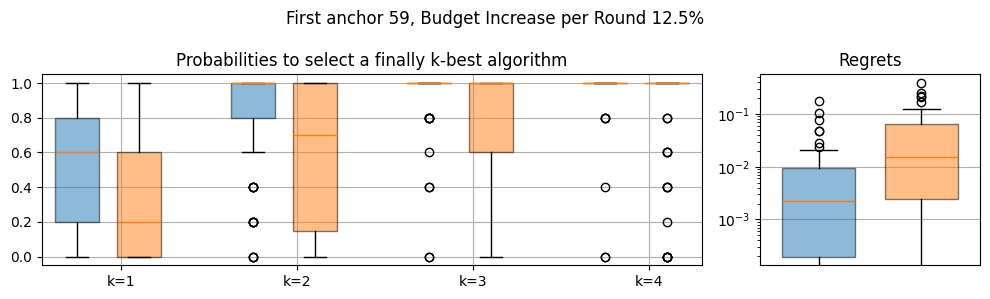

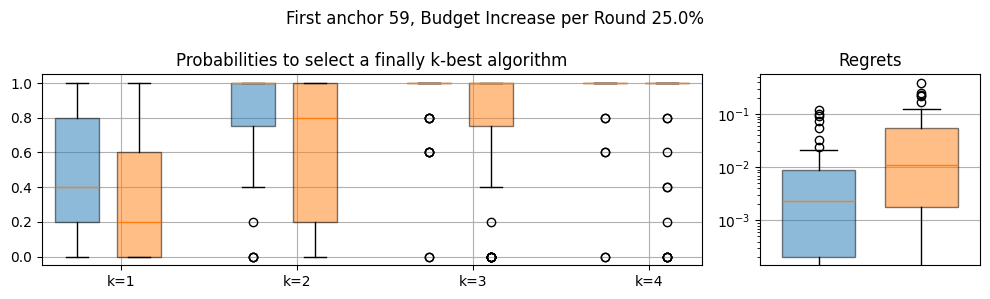

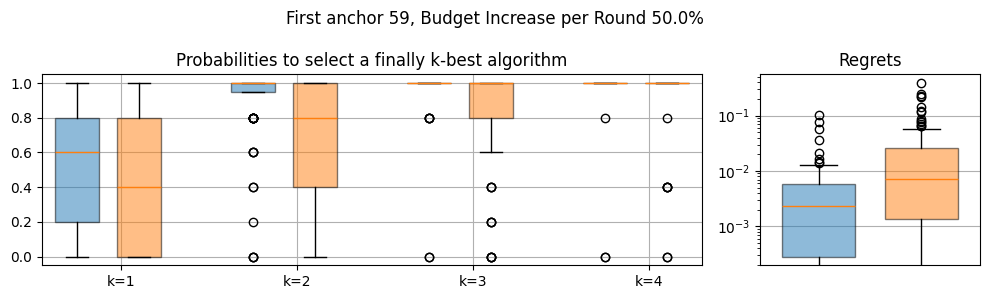

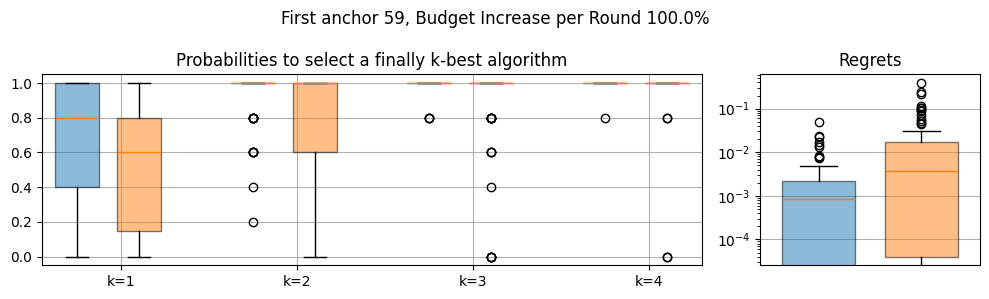

In [17]:
def generate_top_k_selection_heatmaps(df_results, format=".pdf"):
   
    for _, row in df_results.iterrows():

        fig, ax = plt.subplots(figsize=(20, 2))
        sns.heatmap(row["kbest_inclusion_rates"].mean(axis=1).T, cmap="Greens", vmin=0, vmax=1, ax=ax)
        ax.set_xticklabels(dataset_ids_CC18 if row["dataset_filter"] is None else row["dataset_filter"])
        ax.set_xlabel("openml id")
        ax.set_yticklabels(range(1, row["kbest_inclusion_rates"].shape[2] + 1))
        ax.set_ylabel("k")
        ax.set_title(
            f"Probability that the selected algorithm is among the k best (across {row["kbest_inclusion_rates"].shape[1]} outer splits) "
            f"dropping out {row['dropout_rate']} in each round and increasing budget by {row['budget_increase']} starting at {row['start_budget']}"
        )
        ax.grid(alpha=0.5)
        #fig.savefig(f"{folder}/winprobs_{mode}_{dropout_rate}_{budget_increase}_{start_budget}{format}", bbox_inches="tight")
        plt.show()
        plt.close()


def generate_regret_heatmaps(df_results, format=".pdf"):
    for _, row in df_results.iterrows():
        fig, ax = plt.subplots(figsize=(20, 1))
        sns.heatmap(row["regrets"].mean(axis=1).T, cmap="Reds", vmin=0, vmax=0.5, ax=ax)
        ax.set_xticklabels(dataset_ids_CC18 if row["dataset_filter"] is None else row["dataset_filter"])
        ax.set_xlabel("openml id")
        ax.set_title(
            f"Avg. regret that the selected algorithm is among the k best (across {row["kbest_inclusion_rates"].shape[1]} outer splits) "
            f"dropping out {row['dropout_rate']} in each round and increasing budget by {row['budget_increase']} starting at {row['start_budget']}"
        )
        ax.grid(alpha=0.5)
        #fig.savefig(f"{folder}/regrets_{mode}_{dropout_rate}_{budget_increase}_{start_budget}{format}", bbox_inches="tight")
        plt.show()
        plt.close()

def generate_top_k_selection_boxplots(df_results, offset=0, boxplot_kwargs={}, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    else:
        fig = ax.get_figure()
    
    vals = []
    labels = []
    for i, row in df_results.iterrows():    
        agg = row["kbest_inclusion_rates"].mean(axis=1)
        vals.extend(agg.T)
        new_labels = [
            f"({row['start_budget']}, {row['budget_increase']}) - k ={k}"
            for k in range(1 ,5)
        ]
        labels.extend(new_labels)
    assert len(vals) == len(labels)
    boxplot_kwargs["positions"] = offset + np.arange(1, 1 + len(vals))
    ax.boxplot(vals, **boxplot_kwargs)
    #ax.set_xticklabels(labels, rotation=90)
    return fig, ax, {p: l for p, l in zip(boxplot_kwargs["positions"], labels)}

def generate_regret_boxplots(df_results, offset=0, boxplot_kwargs={}, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    else:
        fig = ax.get_figure()
    
    vals = []
    labels = []
    for i, row in df_results.iterrows():    
        agg = row["regrets"].mean(axis=1).flatten()
        vals.append(agg)
        labels.append(f"({row['start_budget']}, {row['budget_increase']})")
    assert len(vals) == len(labels)
    boxplot_kwargs["positions"] = offset + np.arange(1, 1 + len(vals))
    ax.boxplot(vals, **boxplot_kwargs)
    #ax.set_xticklabels(labels, rotation=90)
    return fig, ax, {p: l for p, l in zip(boxplot_kwargs["positions"], labels)}

def create_comparative_plot(df_results_least_crossing, df_results_most_crossing, boxplot_kwargs_least, boxplot_kwargs_most):

    # create figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={"width_ratios": [3, 1]})

    ax = axs[0]
    _, _, labels_least_crossing = generate_top_k_selection_boxplots(
        df_results_least_crossing.sort_values(["budget_increase", "start_budget"]),
        boxplot_kwargs=boxplot_kwargs_least,
        ax=ax
    )
    _, _, labels_most_crossing = generate_top_k_selection_boxplots(
        df_results_most_crossing.sort_values(["budget_increase", "start_budget"]),
        offset=0.35,
        boxplot_kwargs=boxplot_kwargs_most,
        ax=ax
    )
    df_labels = pd.concat([pd.Series(labels_least_crossing), pd.Series(labels_most_crossing)]).sort_index()
    ax.set_xticks(df_labels.index)
    ax.set_xticklabels(df_labels.sort_index(), rotation=80)
    ax.set_xlim([0.8, max(df_labels.index) + 0.2])
    ax.set_title("Probabilities to select a finally k-best algorithm")

    # now the regrets
    ax = axs[1]
    generate_regret_boxplots(df_results_least_crossing.sort_values(["budget_increase", "start_budget"]),
        boxplot_kwargs=boxplot_kwargs_least,
        ax=ax
    )
    generate_regret_boxplots(df_results_most_crossing.sort_values(["budget_increase", "start_budget"]),
        boxplot_kwargs=boxplot_kwargs_most,
        offset=0.35,
        ax=ax
    )
    ax.set_xlim([0.8, 1.55])
    ax.set_title("Regrets")

    for ax in axs:
        ax.grid()
    return fig, axs

for start_budget, budget_increase in it.product([0, 7, 15], [1, 2, 4, 8]):
    fig, axs = create_comparative_plot(
        df_results_least_crossing[
            (df_results_least_crossing["start_budget"] == start_budget) &
            (df_results_least_crossing["budget_increase"] == budget_increase)
        ],
        df_results_most_crossing[
            (df_results_most_crossing["start_budget"] == start_budget) &
            (df_results_most_crossing["budget_increase"] == budget_increase)
        ], 
        boxplot_kwargs_least = {
            "patch_artist": True,
            "boxprops": dict(color='black', facecolor='C0', alpha=0.5),
            "widths": 0.25
        },
        boxplot_kwargs_most = {
            "patch_artist": True,
            "boxprops": dict(color='black', facecolor='C1', alpha=0.5),
            "widths": 0.25
        }
    )
    axs[0].set_xticks(0.25 + np.arange(1, 5))
    axs[0].set_xticklabels([f"{k=}" for k in range(1, 5)], rotation=0)
    axs[1].set_xticks([])
    axs[1].set_yscale("log")
    fig.suptitle(f"First anchor {anchor_list_denser[start_budget]}, Budget Increase per Round {np.round(100 * budget_increase / 8, 2)}%")
    fig.tight_layout()
    fig.savefig(f"plots/successive_halving/{start_budget}_{budget_increase}.pdf", bbox_inches="tight")